# Vector Database Cost Comparison

This notebook compares the costs of three vector storage solutions:
- **Amazon S3 Vectors** (Native S3 vector storage)
- **Amazon OpenSearch Serverless** (Managed vector search)
- **Amazon Aurora PostgreSQL with pgvector** (Relational DB with vector extension)

## Installation
```bash
pip install pandas matplotlib numpy
```

## Scenario: 10 Million Vectors (1536 dimensions)
Typical for a large enterprise knowledge base with OpenAI embeddings.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuration
VECTORS_COUNT = 10_000_000  # 10 million vectors
DIMENSIONS = 1536  # OpenAI embedding dimensions
QUERIES_PER_MONTH = 1_000_000  # 1 million queries per month
UPLOADS_PER_MONTH = 100_000  # 100k new vectors per month

## S3 Vectors Cost Calculation

In [2]:
# S3 Vectors Pricing (US East 1)
s3_storage_per_gb_month = 0.023  # $0.023 per GB per month
s3_query_per_million = 0.40  # $0.40 per million queries
s3_upload_per_million = 0.40  # $0.40 per million uploads

# Calculate storage size
# Each vector: 1536 dimensions * 4 bytes (float32) = 6,144 bytes
# Plus metadata (~500 bytes per vector)
bytes_per_vector = (DIMENSIONS * 4) + 500
total_gb = (VECTORS_COUNT * bytes_per_vector) / (1024**3)

# Monthly costs
s3_storage_cost = total_gb * s3_storage_per_gb_month
s3_query_cost = (QUERIES_PER_MONTH / 1_000_000) * s3_query_per_million
s3_upload_cost = (UPLOADS_PER_MONTH / 1_000_000) * s3_upload_per_million
s3_total_monthly = s3_storage_cost + s3_query_cost + s3_upload_cost

print(f"S3 Vectors Cost Breakdown:")
print(f"Storage: {total_gb:.2f} GB × ${s3_storage_per_gb_month} = ${s3_storage_cost:.2f}/month")
print(f"Queries: {QUERIES_PER_MONTH:,} × ${s3_query_per_million}/million = ${s3_query_cost:.2f}/month")
print(f"Uploads: {UPLOADS_PER_MONTH:,} × ${s3_upload_per_million}/million = ${s3_upload_cost:.2f}/month")
print(f"Total S3 Vectors: ${s3_total_monthly:.2f}/month")

S3 Vectors Cost Breakdown:
Storage: 61.88 GB × $0.023 = $1.42/month
Queries: 1,000,000 × $0.4/million = $0.40/month
Uploads: 100,000 × $0.4/million = $0.04/month
Total S3 Vectors: $1.86/month


## OpenSearch Serverless Cost Calculation

In [3]:
# OpenSearch Serverless Pricing (US East 1)
# OCU (OpenSearch Compute Unit) pricing
ocu_search_per_hour = 0.24  # $0.24 per OCU-hour for search
ocu_indexing_per_hour = 0.24  # $0.24 per OCU-hour for indexing

# Estimate OCUs needed for 10M vectors
# Rule of thumb: 1 OCU can handle ~1-2M vectors for search
search_ocus_needed = max(1, VECTORS_COUNT / 2_000_000)  # Minimum 1 OCU
indexing_ocus_needed = 1  # Assume 1 OCU for ongoing indexing

hours_per_month = 24 * 30  # 720 hours

opensearch_search_cost = search_ocus_needed * ocu_search_per_hour * hours_per_month
opensearch_indexing_cost = indexing_ocus_needed * ocu_indexing_per_hour * hours_per_month
opensearch_total_monthly = opensearch_search_cost + opensearch_indexing_cost

print(f"OpenSearch Serverless Cost Breakdown:")
print(f"Search OCUs: {search_ocus_needed:.1f} × ${ocu_search_per_hour} × {hours_per_month} hours = ${opensearch_search_cost:.2f}/month")
print(f"Indexing OCUs: {indexing_ocus_needed} × ${ocu_indexing_per_hour} × {hours_per_month} hours = ${opensearch_indexing_cost:.2f}/month")
print(f"Total OpenSearch: ${opensearch_total_monthly:.2f}/month")

OpenSearch Serverless Cost Breakdown:
Search OCUs: 5.0 × $0.24 × 720 hours = $864.00/month
Indexing OCUs: 1 × $0.24 × 720 hours = $172.80/month
Total OpenSearch: $1036.80/month


## Aurora PostgreSQL with pgvector Cost Calculation

In [4]:
# Aurora PostgreSQL Pricing (US East 1)
# For 10M vectors, we need a substantial instance
aurora_instance_type = "r6g.2xlarge"  # 8 vCPU, 64 GB RAM
aurora_instance_cost_per_hour = 0.58  # $0.58 per hour

# Storage costs
aurora_storage_per_gb_month = 0.10  # $0.10 per GB per month
aurora_io_per_million = 0.20  # $0.20 per million I/O requests

# Estimate storage needed (vectors + indexes + metadata)
# pgvector stores vectors efficiently, but needs additional space for indexes
aurora_storage_gb = total_gb * 1.5  # 50% overhead for indexes and metadata

# Monthly costs
aurora_compute_cost = aurora_instance_cost_per_hour * hours_per_month
aurora_storage_cost = aurora_storage_gb * aurora_storage_per_gb_month
# Estimate I/O: queries + background maintenance
aurora_io_requests = (QUERIES_PER_MONTH + UPLOADS_PER_MONTH) * 10  # Assume 10 I/O per operation
aurora_io_cost = (aurora_io_requests / 1_000_000) * aurora_io_per_million
aurora_total_monthly = aurora_compute_cost + aurora_storage_cost + aurora_io_cost

print(f"Aurora PostgreSQL Cost Breakdown:")
print(f"Compute ({aurora_instance_type}): ${aurora_instance_cost_per_hour} × {hours_per_month} hours = ${aurora_compute_cost:.2f}/month")
print(f"Storage: {aurora_storage_gb:.2f} GB × ${aurora_storage_per_gb_month} = ${aurora_storage_cost:.2f}/month")
print(f"I/O: {aurora_io_requests:,} requests × ${aurora_io_per_million}/million = ${aurora_io_cost:.2f}/month")
print(f"Total Aurora: ${aurora_total_monthly:.2f}/month")

Aurora PostgreSQL Cost Breakdown:
Compute (r6g.2xlarge): $0.58 × 720 hours = $417.60/month
Storage: 92.82 GB × $0.1 = $9.28/month
I/O: 11,000,000 requests × $0.2/million = $2.20/month
Total Aurora: $429.08/month


## Cost Comparison Summary

In [5]:
# Create comparison DataFrame
comparison_data = {
    'Service': ['S3 Vectors', 'OpenSearch Serverless', 'Aurora PostgreSQL'],
    'Monthly Cost ($)': [s3_total_monthly, opensearch_total_monthly, aurora_total_monthly],
    'Annual Cost ($)': [s3_total_monthly * 12, opensearch_total_monthly * 12, aurora_total_monthly * 12]
}

df = pd.DataFrame(comparison_data)
df['Savings vs S3 (%)'] = ((df['Monthly Cost ($)'] - s3_total_monthly) / s3_total_monthly * 100).round(1)

print("\n" + "="*60)
print("COST COMPARISON SUMMARY")
print("="*60)
print(df.to_string(index=False))

# Calculate savings
opensearch_savings = ((opensearch_total_monthly - s3_total_monthly) / opensearch_total_monthly * 100)
aurora_savings = ((aurora_total_monthly - s3_total_monthly) / aurora_total_monthly * 100)

print(f"\nKey Insights:")
print(f"• S3 Vectors is {opensearch_savings:.0f}% cheaper than OpenSearch Serverless")
print(f"• S3 Vectors is {aurora_savings:.0f}% cheaper than Aurora PostgreSQL")
print(f"• Annual savings with S3 Vectors: ${(opensearch_total_monthly - s3_total_monthly) * 12:,.0f} vs OpenSearch")


COST COMPARISON SUMMARY
              Service  Monthly Cost ($)  Annual Cost ($)  Savings vs S3 (%)
           S3 Vectors          1.863173        22.358072                0.0
OpenSearch Serverless       1036.800000     12441.600000            55547.0
    Aurora PostgreSQL        429.081561      5148.978729            22929.6

Key Insights:
• S3 Vectors is 100% cheaper than OpenSearch Serverless
• S3 Vectors is 100% cheaper than Aurora PostgreSQL
• Annual savings with S3 Vectors: $12,419 vs OpenSearch


## Visualization

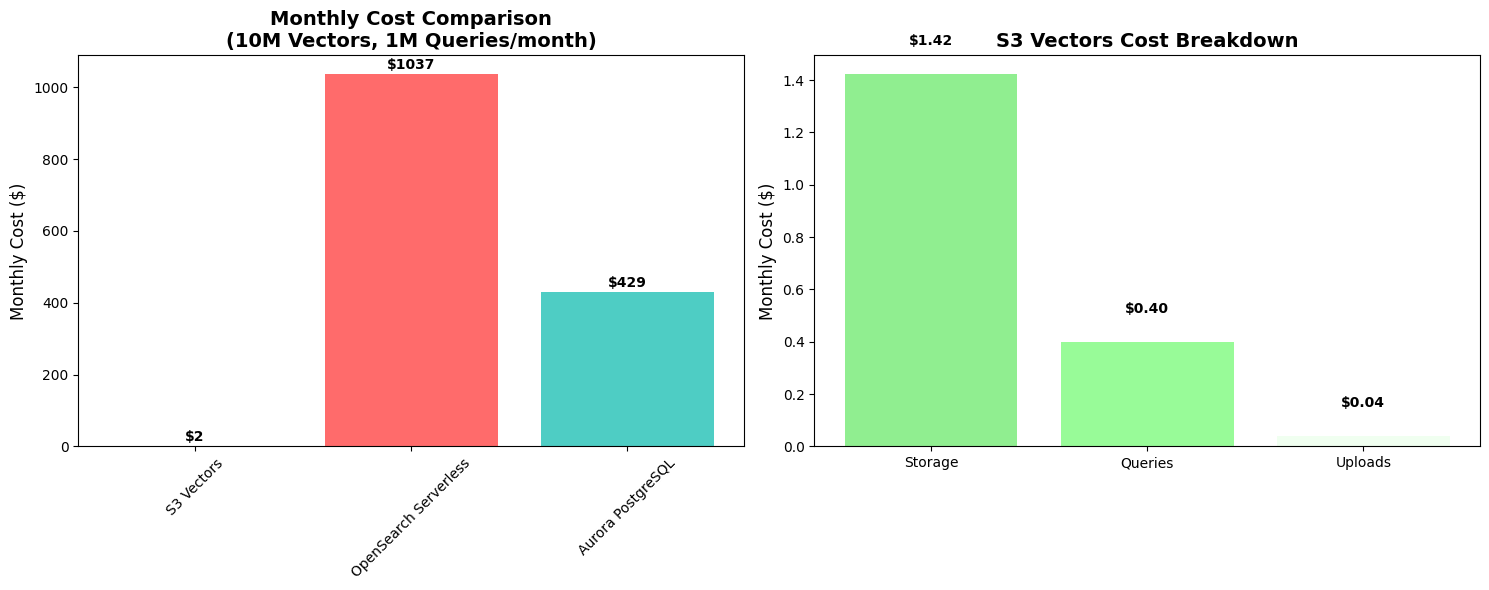


Cost per million vectors stored:
• S3 Vectors: $0.19/month per million vectors
• OpenSearch Serverless: $103.68/month per million vectors
• Aurora PostgreSQL: $42.91/month per million vectors


In [6]:
# Create cost comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Monthly cost comparison
services = df['Service']
monthly_costs = df['Monthly Cost ($)']
colors = ['#2E8B57', '#FF6B6B', '#4ECDC4']  # Green for S3 (cheapest)

bars1 = ax1.bar(services, monthly_costs, color=colors)
ax1.set_title('Monthly Cost Comparison\n(10M Vectors, 1M Queries/month)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Monthly Cost ($)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, cost in zip(bars1, monthly_costs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'${cost:.0f}', ha='center', va='bottom', fontweight='bold')

# Cost breakdown for S3 Vectors
s3_components = ['Storage', 'Queries', 'Uploads']
s3_costs = [s3_storage_cost, s3_query_cost, s3_upload_cost]
colors_s3 = ['#90EE90', '#98FB98', '#F0FFF0']

bars2 = ax2.bar(s3_components, s3_costs, color=colors_s3)
ax2.set_title('S3 Vectors Cost Breakdown', fontsize=14, fontweight='bold')
ax2.set_ylabel('Monthly Cost ($)', fontsize=12)

# Add value labels
for bar, cost in zip(bars2, s3_costs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'${cost:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print cost per vector
print(f"\nCost per million vectors stored:")
for service, cost in zip(services, monthly_costs):
    cost_per_million = (cost / VECTORS_COUNT) * 1_000_000
    print(f"• {service}: ${cost_per_million:.2f}/month per million vectors")

## Performance & Feature Comparison

In [7]:
# Feature comparison table
features_data = {
    'Feature': [
        'Query Latency',
        'Scalability',
        'Maintenance',
        'Metadata Filtering',
        'ACID Transactions',
        'Backup/Recovery',
        'Multi-AZ',
        'Setup Complexity'
    ],
    'S3 Vectors': [
        'Sub-second (cold), ~100ms (warm)',
        'Unlimited (2B vectors/index)',
        'Fully managed',
        'Rich metadata support',
        'No',
        'Built-in S3 durability',
        'Yes (S3 cross-region)',
        'Low (native S3)'
    ],
    'OpenSearch Serverless': [
        '~50-200ms',
        'Auto-scaling OCUs',
        'Fully managed',
        'Advanced filtering',
        'No',
        'Automated snapshots',
        'Yes',
        'Medium (collection setup)'
    ],
    'Aurora PostgreSQL': [
        '~10-50ms',
        'Limited by instance size',
        'Managed DB, manual tuning',
        'SQL-based filtering',
        'Yes (full ACID)',
        'Point-in-time recovery',
        'Yes',
        'High (DB + pgvector setup)'
    ]
}

features_df = pd.DataFrame(features_data)
print("\n" + "="*80)
print("FEATURE COMPARISON")
print("="*80)
print(features_df.to_string(index=False))


FEATURE COMPARISON
           Feature                       S3 Vectors     OpenSearch Serverless          Aurora PostgreSQL
     Query Latency Sub-second (cold), ~100ms (warm)                 ~50-200ms                   ~10-50ms
       Scalability     Unlimited (2B vectors/index)         Auto-scaling OCUs   Limited by instance size
       Maintenance                    Fully managed             Fully managed  Managed DB, manual tuning
Metadata Filtering            Rich metadata support        Advanced filtering        SQL-based filtering
 ACID Transactions                               No                        No            Yes (full ACID)
   Backup/Recovery           Built-in S3 durability       Automated snapshots     Point-in-time recovery
          Multi-AZ            Yes (S3 cross-region)                       Yes                        Yes
  Setup Complexity                  Low (native S3) Medium (collection setup) High (DB + pgvector setup)


## Recommendations

### Choose S3 Vectors when:
- **Cost is a primary concern** (90%+ savings)
- You need **massive scale** (billions of vectors)
- **Subsecond latency is acceptable**
- You want **zero infrastructure management**
- Building **new RAG applications**

### Choose OpenSearch Serverless when:
- You need **advanced search features** (faceting, aggregations)
- **Hybrid search** (vector + text) is required
- You have **existing OpenSearch expertise**
- **Complex analytics** on vector data

### Choose Aurora PostgreSQL when:
- You need **ACID transactions**
- **Existing PostgreSQL applications** to extend
- **Complex relational queries** with vectors
- **Lowest possible latency** is critical
- **Hybrid workloads** (transactional + vector)

## Cost Scaling Analysis

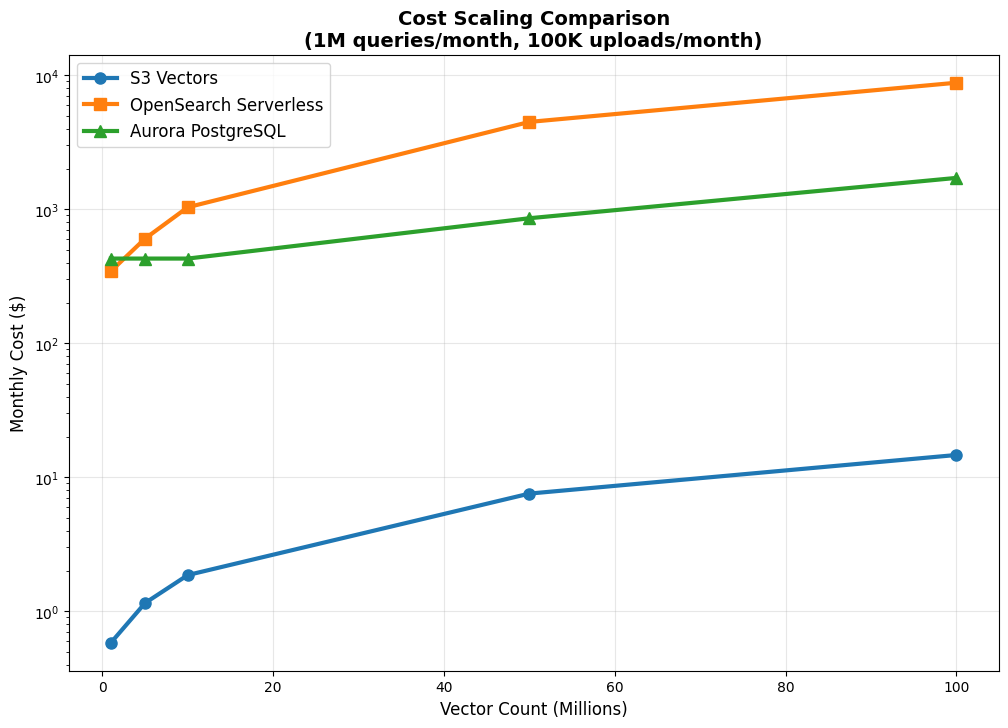


Scaling Analysis:
 Vectors (M)  S3 Vectors  OpenSearch      Aurora
         1.0    0.582317       345.6  429.081561
         5.0    1.151586       604.8  429.081561
        10.0    1.863173      1036.8  429.081561
        50.0    7.555863      4492.8  858.163122
       100.0   14.671727      8812.8 1716.326243

At 100M vectors:
• S3 Vectors saves $105,578/year vs OpenSearch
• S3 Vectors saves $20,420/year vs Aurora


In [8]:
# Analyze cost scaling with different vector counts
vector_counts = [1_000_000, 5_000_000, 10_000_000, 50_000_000, 100_000_000]
scaling_results = []

for count in vector_counts:
    # S3 Vectors scaling
    gb = (count * bytes_per_vector) / (1024**3)
    s3_cost = gb * s3_storage_per_gb_month + s3_query_cost + s3_upload_cost
    
    # OpenSearch scaling (more OCUs needed)
    search_ocus = max(1, count / 2_000_000)
    os_cost = (search_ocus + 1) * ocu_search_per_hour * hours_per_month
    
    # Aurora scaling (larger instances needed)
    if count <= 10_000_000:
        aurora_cost = aurora_total_monthly
    elif count <= 50_000_000:
        aurora_cost = aurora_total_monthly * 2  # Larger instance
    else:
        aurora_cost = aurora_total_monthly * 4  # Much larger instance
    
    scaling_results.append({
        'Vectors (M)': count / 1_000_000,
        'S3 Vectors': s3_cost,
        'OpenSearch': os_cost,
        'Aurora': aurora_cost
    })

scaling_df = pd.DataFrame(scaling_results)

# Plot scaling comparison
plt.figure(figsize=(12, 8))
plt.plot(scaling_df['Vectors (M)'], scaling_df['S3 Vectors'], 'o-', label='S3 Vectors', linewidth=3, markersize=8)
plt.plot(scaling_df['Vectors (M)'], scaling_df['OpenSearch'], 's-', label='OpenSearch Serverless', linewidth=3, markersize=8)
plt.plot(scaling_df['Vectors (M)'], scaling_df['Aurora'], '^-', label='Aurora PostgreSQL', linewidth=3, markersize=8)

plt.xlabel('Vector Count (Millions)', fontsize=12)
plt.ylabel('Monthly Cost ($)', fontsize=12)
plt.title('Cost Scaling Comparison\n(1M queries/month, 100K uploads/month)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print("\nScaling Analysis:")
print(scaling_df.to_string(index=False))

# Calculate savings at 100M vectors
s3_100m = scaling_df.iloc[-1]['S3 Vectors']
os_100m = scaling_df.iloc[-1]['OpenSearch']
aurora_100m = scaling_df.iloc[-1]['Aurora']

print(f"\nAt 100M vectors:")
print(f"• S3 Vectors saves ${(os_100m - s3_100m) * 12:,.0f}/year vs OpenSearch")
print(f"• S3 Vectors saves ${(aurora_100m - s3_100m) * 12:,.0f}/year vs Aurora")